# Introduction

In this document I will critique a common method for data-dependent quantization for deep learning and propose a similar but improved formula. 

The standard formula for linear quantization (like that implemented in `quantized_linear`) on an input tensor `x` is

1. Divide `x` by a quantization scale
2. Clip `x` to a specified range
3. Round to the nearest integer
4. Multiply the rounded result by the quantization scale

The quantization scale essentially determines the "representable range" of values in the quantizer, where larger ranges come at the cost of larger spaces between the quantized values. 

A standard choice for the quantization scale is the minimum value that allows for all of the input data to avoid the "clipping" step (See III-C [here](https://arxiv.org/pdf/2103.13630.pdf)). This is implemented as `auto` quantization in qkeras, and is the main focus of the document. 

# Implementation

For a symmetric quantizer, we can compute this quantization scale as double the max absolute value of `x` divided by the length of the full range of clipped values. This is implemented below.

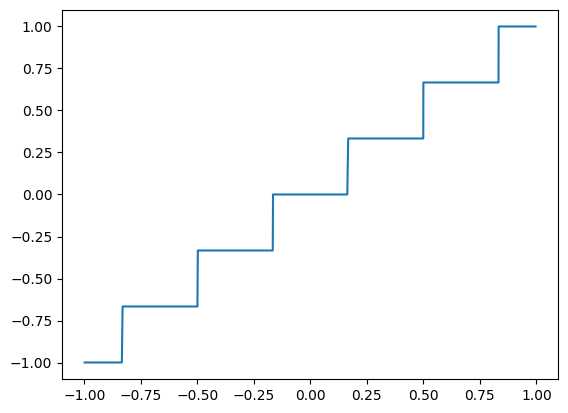

In [88]:
import tensorflow as tf
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt

def get_quantization_scale(x, clip_range):

  data_max = K.max(tf.math.abs(x))
  quantization_scale = (data_max * 2) / clip_range

  return quantization_scale


def auto_quantization(x, bits):

  clip_min = -K.pow(2.0, bits - 1) + 1
  clip_max = K.pow(2.0, bits - 1) - 1

  clip_range = clip_max - clip_min

  quantization_scale = get_quantization_scale(x, clip_range)

  scaled_x = x / quantization_scale
  clipped_scaled_x = K.clip(scaled_x, clip_min, clip_max)
  scaled_xq = tf.round(clipped_scaled_x)
  xq = scaled_xq * quantization_scale

  return xq

bits = 3
  
data = tf.sort(tf.random.uniform((1000,), minval=-1, maxval=1))
plt.plot(data, auto_quantization(data, bits))
plt.show()

The motivation for this choice of quantization scale is fairly straightforward- we want all of our data to be in the representable range, and nothing more. If, for example, we assume that our data is distributed uniformly around an interval, we should expect that it is best to match that interval with the clipped interval in the data. 

However, upon closer examination, we see that this is not quite optimal. In the plot above, you can see that the "steps" of the staircase are a bit too short on the end, meaning we're giving extra precision to the edges of our distribution. 

Let's be a bit more precise about what we mean by "optimal", and then we can see about finding a better idea. 



# Quantization loss computation

When quantizing data, we often try to minimize "quantization loss", which is just the squared average difference between the original data and the quantized data. Let's calculate the quantization loss for the above quantizer and data uniformly distributed in the interval [-1, 1]. 

*Note: This calculation and similar calculations are verified emprically below, so feel free to skip the details here.*

With $b$ bits and a symmetric quantizer, we have $2^b - 1$ output values placed at points $k/(2^{b-1} - 1)$ for integer $k$ between $-2^{b-1} + 1$ and $2^{b-1} - 1$. In order to determine the expected squared quantization error for the whole interval, we can just compute the expected error on a uniform distribution on the half-interval $[0, 1/(2^{b} - 2)]$, since the total computation is just $2^b - 1$ copies of this. Since all points on this interval are quantized to 0, the expected squared error on this interval is
$$
(2^b - 2)\int_0^{1/(2^b - 2)} x^2dx = \frac{1}{3}(2^{b} -2) \cdot (2^b - 2) ^{-3} = \frac{1}{3(2^b - 2)^2}.
$$

# A better idea


Is this the best that we can do? What we want to maximize here is points getting mapped to a quantized value that is very close to them. However, since no data is getting outside of the max value of the data, we will have no examples of data getting mapped from $max(x) + \epsilon \to \max(x)$.

What if we pushed the quantization scale down a bit so that  each output point is surrounded by identical uniform distributions, rather than having the distributions around the edge points cut off on their outer halves?

To be more specific, let's change the computation of the quantization scale so that we divide by the `clip_range + 1` rather than just `clip_range`. 


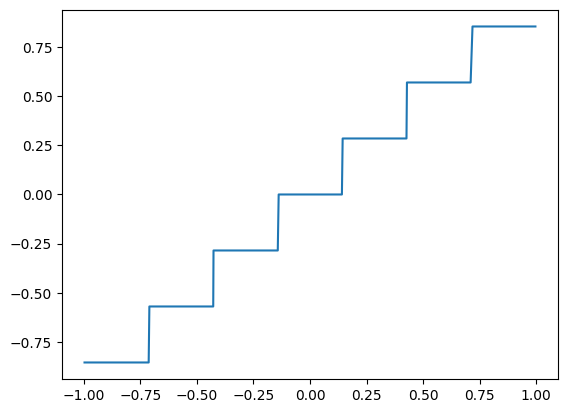

In [89]:
def get_quantization_scale2(x, clip_range):

  data_max = K.max(tf.math.abs(x))
  quantization_scale = (data_max * 2) / (clip_range + 1)

  return quantization_scale


def auto_quantization2(x, bits):

  clip_min = -K.pow(2.0, bits - 1) + 1
  clip_max = K.pow(2.0, bits - 1) - 1

  clip_range = clip_max - clip_min

  quantization_scale = get_quantization_scale2(x, clip_range)

  scaled_x = x / quantization_scale
  clipped_scaled_x = K.clip(scaled_x, clip_min, clip_max)
  scaled_xq = tf.round(clipped_scaled_x)
  xq = scaled_xq * quantization_scale

  return xq

bits = 3
  
data = tf.sort(tf.random.uniform((1000,), minval=-1, maxval=1))
plt.plot(data, auto_quantization2(data, bits))
plt.show()

Looks better!

# A better quantization loss

Let's compute the expected loss on the uniform interval considered above with the new quantizer. We again have $2^b - 1$ outputs, but they are now located at points $2k / (2^{b} - 1)$ for integer $k$ between $-2^{b-1} + 1$ and $2^{b-1} - 1$. We compute the expected loss in a similar fashion, focusing on a uniform interval between $0$ and $1/(2^b - 1)$. 
$$
(2^b - 1)\int_0^{1/(2^b - 1)} x^2dx = \frac{1}{3}(2^{b} -1) \cdot (2^b - 1) ^{-3} = \frac{1}{3(2^b - 1)^2}.
$$
Since
$$
\frac{1}{3(2^b - 1)^2} < \frac{1}{3(2^b - 2)^2}
$$
this quantizer achieves a lower quantization loss. 


# Empirical validation and plots

Below we support the above computations with a small simulation. 

b = 2
original_quantizer_error = 0.08330319
expected_original_error = 0.08333333333333333
improved_quantizer_error = 0.037058733
expected_improved_error = 0.037037037037037035



<Figure size 640x480 with 0 Axes>

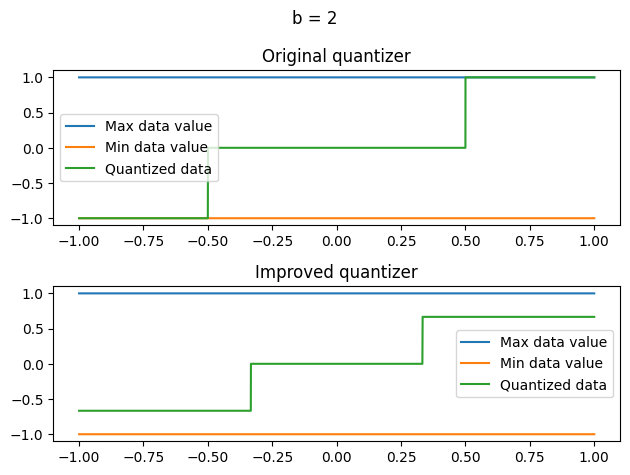

b = 3
original_quantizer_error = 0.009139397
expected_original_error = 0.009259259259259259
improved_quantizer_error = 0.006746591
expected_improved_error = 0.006802721088435374



<Figure size 640x480 with 0 Axes>

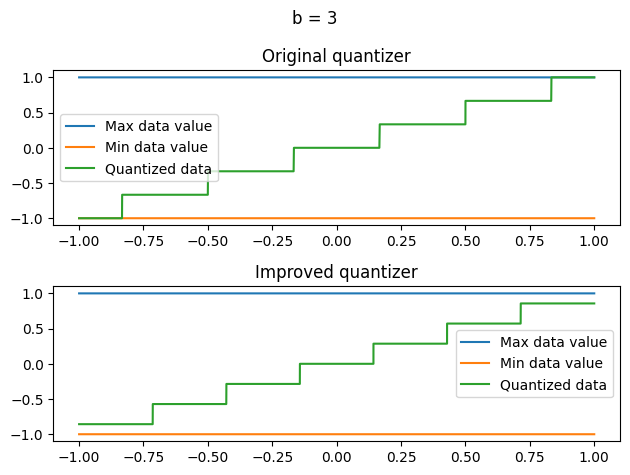

b = 8
original_quantizer_error = 5.1555253e-06
expected_original_error = 5.166677000020666e-06
improved_quantizer_error = 5.080849e-06
expected_improved_error = 5.126233499935922e-06



<Figure size 640x480 with 0 Axes>

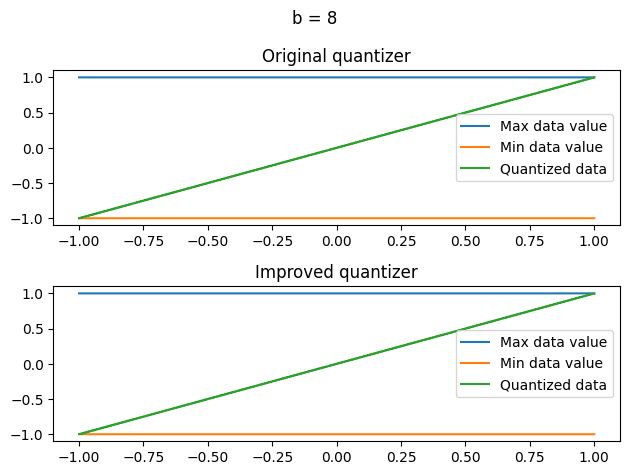

In [96]:
def standard_quantization(x, bits, data_max, *, original):
  """Standard quantization with user-determined quantization scale"""

  clip_min = -K.pow(2.0, bits - 1) + 1
  clip_max = K.pow(2.0, bits - 1) - 1

  clip_range = clip_max - clip_min

  if original:
    quantization_scale = data_max * 2 / clip_range
  else:
    quantization_scale = data_max * 2 / (clip_range + 1)

  scaled_x = x / quantization_scale
  clipped_scaled_x = K.clip(scaled_x, clip_min, clip_max)
  scaled_xq = tf.round(clipped_scaled_x)
  xq = scaled_xq * quantization_scale

  return xq

def quantizer_plots(b, data, original_data, improved_data):
  """Plot quantizer data"""

  plt.clf()
  fig, ax = plt.subplots(2)
  for i in [0, 1]:
    ax[i].plot(data, tf.ones_like(data), label='Max data value')
    ax[i].plot(data, -tf.ones_like(data), label='Min data value')
  ax[0].plot(data, original_data, label='Quantized data')
  ax[0].set_title('Original quantizer')
  ax[1].plot(data, improved_data, label='Quantized data')
  ax[1].set_title('Improved quantizer')
  ax[0].legend()
  ax[1].legend()
  fig.suptitle(f'{b = }')
  fig.tight_layout()
  plt.show()


# Uniform random data between -1 and 1
N = 10000
data = tf.sort(tf.random.uniform((N,)) * 2 - 1)

for b in [2, 3, 8]:

  original_quantizer_data = standard_quantization(data, b, 1.0, original=True)
  improved_quantizer_data = standard_quantization(data, b, 1.0, original=False)

  original_quantizer_error = ((original_quantizer_data - data).numpy() ** 2).mean()
  improved_quantizer_error = ((improved_quantizer_data - data).numpy() ** 2).mean()

  expected_original_error = 1 / (3 * (2 ** b - 2) ** 2)
  expected_improved_error = 1 / (3 * (2 ** b - 1) ** 2)

  print(f'{b = }')
  print(f'{original_quantizer_error = }')
  print(f'{expected_original_error = }')
  print(f'{improved_quantizer_error = }')
  print(f'{expected_improved_error = }')
  print()

  # plots
  quantizer_plots(b, data, original_quantizer_data, improved_quantizer_data)

# Importance for binary quantization

As you can see in the above data, this distinction matters less the more bits you have in your data. It's highly important for the 3-bit example, and not so important for the 8-bit. 

I did not include binary quantization in the above example since the formula for quantization differs slightly in this case, but this distinction is actually most important here. 

For binary quantization, you often use a scaled sign function for your forward pass. It's clear that if you want to minimize quantization noise on uniform data, you should scale the sign function by half of the max of the data, and this is what will happen when using the improved formula. However, with the original formula, you scale by the full max of the data, which is highly suboptimal. 

See the implementation below.

original_binary_error = 0.3340325
improved_binary_error = 0.083611876


<Figure size 640x480 with 0 Axes>

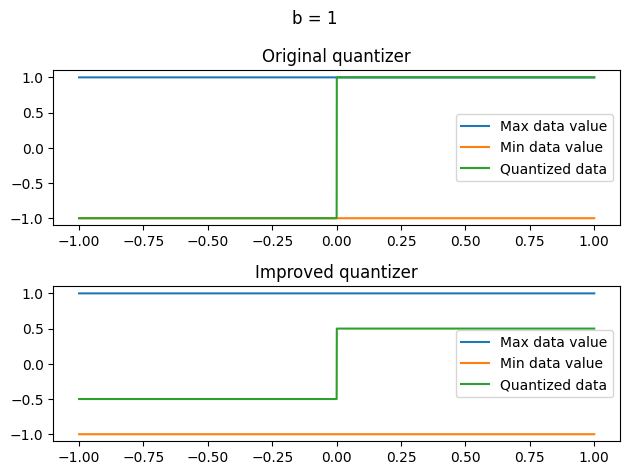

In [97]:
def binary_quantizer(x, data_max, *, original):

  clip_min = -0.5
  clip_max = 0.5
  shift = 0.5

  clip_range = clip_max - clip_min

  if original:
    quantization_scale = data_max * 2 / clip_range
  else:
    quantization_scale = data_max * 2 / (clip_range + 1)

  scaled_x = x / quantization_scale
  clipped_scaled_x = K.clip(scaled_x, clip_min, clip_max)
  scaled_xq = tf.round(clipped_scaled_x - shift) + shift
  xq = scaled_xq * quantization_scale

  return xq

original_binary_data = binary_quantizer(data, 1.0, original=True)
improved_binary_data = binary_quantizer(data, 1.0, original=False)

original_binary_error = ((original_binary_data - data).numpy() ** 2).mean()
improved_binary_error = ((improved_binary_data - data).numpy() ** 2).mean()

print(f'{original_binary_error = }')
print(f'{improved_binary_error = }')

quantizer_plots(1, data, original_binary_data, improved_binary_data)

# Model tests

Here we test both the original formula and the new formula for auto quantization on MNIST. We give the validation scores on a simple model trained over 10 epochs. 

In [93]:
data = [
  {
    'quantizer_type': 'improved',
    'bits': 1,
    'validation accuracy': .9792,
  },
  {
    'quantizer_type': 'improved',
    'bits': 2,
    'validation accuracy': .9881,
  },
  {
    'quantizer_type': 'improved',
    'bits': 8,
    'validation accuracy': .9910,
  },
  {
    'quantizer_type': 'original',
    'bits': 1,
    'validation accuracy': .9691,
  },
  {
    'quantizer_type': 'original',
    'bits': 2,
    'validation accuracy': .9812,
  },
  {
    'quantizer_type': 'original',
    'bits': 8,
    'validation accuracy': .9916,
  },
]

display(pd.DataFrame(data).sort_values(by='bits'))

,quantizer_type,bits,validation accuracy
0,improved,1,0.9792
3,original,1,0.9691
1,improved,2,0.9881
4,original,2,0.9812
2,improved,8,0.9910
5,original,8,0.9916


As expected, the improvements are more significant for fewer-bit quantizers. 

# Conclusion

The proposed formula for scaling the max of the data for auto quantization allows for 
1. Better quantization error on uniform data
2. A simple formula that unites an improved formula for multi-bit quantization and the obvious choice for binary quantization. 

I would like to implement this in `quantized_linear` in qkeras. 

For further investigations and some subtleties with the above reasoning, see the Appendix. 

# Appendix A: Un-biasing the max estimate

In the above examples, we assumed 
1. We knew that the data distribution was uniform, and
2. We knew the bounds of the uniform distribution. 

(1) is problematic, and we'll come back to it later. (2) has issues as well, and we'll deal with the first issue here. 

In the examples above, we hard-coded the max value of the data, which of course you can't know in practice even if you know the distribution is uniform. You can of course estimate the max of the distribution with the max of the sample, but this estimate will be biased. Of course, the highest value of the sample will likely be lower than the highest achievable value. 

Given $n$ IID draws from a uniform distribution on [0,1], the expected value of the max of these is $\frac{n}{n+1}$ ([source](https://jamesmccammon.com/2017/02/18/finding-the-expected-value-of-the-maximum-of-n-random-variables/)). Thus if we want an unbiased estimate of the max, then we need to scale the max of the data up by $1 + \frac{1}{n}$. 

I do not think this is worth implementing, since it would complicate things unnecessarily and relies heavily on the uniform distribution assumption. 



# Appendix B: Outliers

Of course a statistic like the max of a sample is going to be sensitive to outliers. [Past work](https://arxiv.org/pdf/1809.04191.pdf) has made use of percentiles to determine the quantization scale, and in their case 99.99th percentile was best for 8-bit layers, while 99.9 was best for 4-bit layers. This may be due to the reasoning in the main section of this document, where it is best to reduce the quantization scale a small amount for high bit quantizers and a larger amount for small bit quantizers. Given that the percentiles are so high, it does not seem that outliers made a large difference in training. 

Percentile quantizers are likely worth implementing. In [this paper](https://arxiv.org/pdf/2004.09602.pdf), percentile quantizers perform well compared to an array of alternative quantization methods, including the max. 

# Appendix C: Gaussians

The choice of a uniform distrubition above was mostly for demonstrative purposes. It is worth studying emprically what the distributions of activation values in quantized networks actually look like, and whether the uniformity assumption is a reasonable one. 

Here, I'm going to do some preliminary work on optimal quantization scales for Gaussians. In particular, I'm going to empirically determine the best `b`-bit quantization scale for a Gaussian distribution with a center of 0 and std of 1. It will be easy to determine, then the best quantization scale for any Gaussian centered at 0 once its variance is computed. 

This could be the first step towards a variance-based auto-quantizer. 

In [54]:
import numpy as np
from functools import partial

N = 5000
gaussian_data = tf.random.normal((N,))

In [77]:
def standard_quantization(x, bits, quantization_scale):

  clip_min = -K.pow(2.0, bits - 1) + 1
  clip_max = K.pow(2.0, bits - 1) - 1

  binary = bits == 1

  shift = 0.5 if binary else 0.0
  clip_min = -0.5 if binary else clip_min
  clip_max = 0.5 if binary else clip_max

  scaled_x = x / quantization_scale
  clipped_scaled_x = K.clip(scaled_x, clip_min, clip_max)
  scaled_xq = tf.round(clipped_scaled_x - shift) + shift
  xq = scaled_xq * quantization_scale

  return xq


def get_quantization_loss(quantization_scale, b):
  
  quantized_data = standard_quantization(gaussian_data, b, quantization_scale)
  return ((quantized_data - gaussian_data).numpy() ** 2).mean()

In [78]:
from scipy.optimize import fmin
import pandas as pd

bit_list = [1, 2, 3, 4, 5, 6]
min_quantization_scales = []

for b in bit_list:
  res = fmin(get_quantization_loss, 0.5, args=(b,), disp=False)
  # print(b, res)
  min_quantization_scales.append(res[0])

pd.DataFrame({'bits': bit_list, 'min quantization scale': min_quantization_scales})

,bits,min quantization scale
0,1,1.596875
1,2,1.210547
2,3,0.649023
3,4,0.343359
4,5,0.199316
5,6,0.108691


The value for `b=1`, at least, can be determined analytically as twice the mean of the [half-normal Gaussian distribution](https://en.wikipedia.org/wiki/Half-normal_distribution#:~:text=degree%20of%20freedom.-,The%20half%2Dnormal%20distribution%20is%20a%20special%20case%20of%20the,of%20the%20half%2Dnormal%20distribution.), which is known to be given by the formula below. 

In [79]:
from math import pi
2 * np.sqrt(2/pi)

1.5957691216057308

The other values may be possible to determine analytically, but I'm confident this is hard, since the computations likely require inverting the Gaussian CDF. I'm very happy to dig into this if there is some belief that this is helpful, but I imagine there are better uses of my time. 
